In [2]:
# Libraries 
import torch
from torch.nn import functional as F
from datasets import load_dataset
import os
import pickle
import random
from BigramLanguageModelTrain import utilTools as ut
from BigramLanguageModelTrain import BigramLanguageModel
random.seed(1330) 

In [3]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") #m1 gpu
batch_size = 64 # how many independent sequences will we process in parallel
block_size = 256 # what is the maximum context length for predictions
n_embd = 384
n_head = 6
dropout = 0.2

In [4]:
ds = load_dataset("statworx/haiku")
haikutext = '\n'.join(ds['train']['text'])


In [5]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(haikutext)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

In [6]:
model = BigramLanguageModel(block_size, vocab_size, n_embd, n_head, dropout, device)
model.load_state_dict(torch.load(f'./model_weights/model_weights_21000.pth', weights_only=True))
m = model.to(device)

/opt/anaconda3/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


## Generating Haikus with 0s context

In [20]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
Haikus =  decode(model.generate(context, max_new_tokens=1000)[0].tolist())
print(Haikus)


Yes, I'm so ready. / To this hour, in the pub. / I, it's ok a day.
I'll walk until soon. / Fat tomorrow in these, but. / I'm gonna proud it.
Do you ever try? / Tried met your deserve that. / Send family, that's.
I hate being honed. / And like this, but like that. / This had done now, but.
Uhh, thy did resulve? / People are comici quite Joje. / In Hallow comment.
I keep calling the. / Remember I don't be here. / Granded peaces extra.
I'm deependwiced but. / 'Salad and then I want. / To Austeep, siring to powe.
Uncourse is a great. / Act like a tacorn continue. / Radiabled brought.
Deep in arch. / Wind sparrows roamed ringing. / The path, of us rise.
Sometimes I don't caugh. / I candle demoise. / From home backward or not.
Still, bat has alter. / As he's much better colours. / He'll always pretty.
Oh, really, but I'd. / Be itch out till I'm sorry. / No jealout to love.
I really think I go. / Throw out for th the gym week. / With this symphom.
I can peace this mommate. / And othericaphy,

## The percentage of actual words in generated haikus

In [46]:
import nltk
from nltk.corpus import words
import re

# Download the words corpus (if you haven't already)
nltk.download('words')

# Get the list of valid English words from nltk corpus
valid_words = set(words.words())

def percentage_real_words(input_string):
    # Remove non-alphabetic characters and split the string into words
    word_list = re.findall(r'\b[a-zA-Z]+\b', input_string)
    
    # Count the real words
    real_word_count = sum(1 for word in word_list if word.lower() in valid_words)
    
    # Calculate the percentage of real words
    if len(word_list) == 0:
        return 0  # To avoid division by zero
    return (real_word_count / len(word_list)) * 100

# Example usage
tenKtest = decode(model.generate(context, max_new_tokens=10000)[0].tolist())
real_word_percentage = percentage_real_words(tenKtest)
print(f"Percentage of real words: {real_word_percentage:.2f}%")

[nltk_data] Downloading package words to
[nltk_data]     /Users/clayolsen1/nltk_data...
[nltk_data]   Package words is already up-to-date!


Percentage of real words: 81.63%


After generating about 20000 characters of the haiku, approximately 80-85% of the words generated are actual words found in the nltk dictionary. We can see this in the printed output of the Haiku where there are some general misspellings or mushing of words to make artificial fake words.

# Checking the Syllable counts for the 3 lines of Haiku

Haikus generally are in the form of 5-7-5 syllables. I noticed in the huggingface dataset this is not 100% true and that there seems to be some simple 3 line poems in there that do not maintain the exact structure. If we wanted to produce Haikus that both made some sense and maintained the syllable structure more stringently, we would need to be more strict in our data and find many more examples. Nonetheless, we can compare the syllable structure of what we produce compared to the dataset as many of the examples at least maintain that the first and third line have less syllables than the middle line.

In [47]:
#Functions for counting syllables in each section using Pyphen as vowel seperating using regular expression is qutie unreliable

import pyphen

# Initialize pyphen for English syllable splitting
dic = pyphen.Pyphen(lang='en')

# Function to count syllables in a sentence using pyphen
def count_syllables(sentence):
    words = sentence.split()
    syllable_count = 0
    for word in words:
        # Use pyphen to split word into syllables
        syllables = dic.inserted(word)
        syllable_count += syllables.count('-') + 1  # Count the number of syllables
    return syllable_count

# Function to process the string and count syllables for each sentence position
def count_syllables_in_lines(text):
    # Split text into lines
    lines = text.strip().split('\n')
    
    # Initialize counters for syllables in each sentence position
    first_sentence_syllables = []
    second_sentence_syllables = []
    third_sentence_syllables = []
    
    # Process each line
    for line in lines:
        # Split the line into sentences based on " / " separator
        sentences = re.split(r'[\.,!?]?\s*/\s*', line)
        
        # Track syllables for each sentence position
        if len(sentences) >= 3:
            first_sentence_syllables.append(count_syllables(sentences[0]))
            second_sentence_syllables.append(count_syllables(sentences[1]))
            third_sentence_syllables.append(count_syllables(sentences[2]))
    
    return first_sentence_syllables, second_sentence_syllables, third_sentence_syllables

In [60]:
input_text = tenKtest

# Run the function on the input text
first_syllables, second_syllables, third_syllables = count_syllables_in_lines(tenKtest)
#Last sentences are probably cutoff midway
first_syllables, second_syllables, third_syllables = first_syllables[:-1], second_syllables[:-1], third_syllables[:-1]
# Output the results
print(f"First sentences syllable counts: {first_syllables}")
print(f"Second sentences syllable counts: {second_syllables}")
print(f"Third sentences syllable counts: {third_syllables}")

First sentences syllable counts: [3, 3, 4, 1, 4, 5, 5, 6, 3, 3, 5, 3, 3, 3, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 6, 4, 3, 4, 4, 5, 4, 6, 5, 3, 4, 4, 6, 4, 5, 5, 5, 2, 3, 3, 3, 4, 4, 3, 5, 3, 4, 5, 4, 4, 5, 4, 5, 5, 4, 4, 4, 4, 5, 4, 4, 4, 5, 5, 5, 5, 5, 4, 2, 4, 5, 6, 4, 5, 5, 4, 5, 6, 5, 4, 5, 5, 5, 4, 4, 3, 6, 5, 5, 5, 5, 5, 4, 4, 5, 5, 5, 6, 4, 2, 2, 4, 3, 2, 4, 6, 2, 4, 4, 3, 5, 1, 5, 3, 2, 3, 3, 3, 2, 5, 3, 5, 4, 3, 5, 5, 4, 5, 5, 5, 4, 5, 5, 4, 3, 5, 5, 5, 5, 4]
Second sentences syllable counts: [2, 6, 4, 6, 7, 6, 4, 5, 5, 4, 5, 3, 6, 3, 4, 6, 3, 7, 4, 5, 3, 9, 4, 4, 6, 5, 7, 7, 6, 4, 5, 6, 7, 7, 6, 9, 5, 7, 5, 1, 8, 4, 2, 2, 4, 7, 7, 6, 4, 4, 6, 7, 7, 6, 7, 6, 8, 6, 8, 6, 5, 7, 6, 7, 7, 8, 6, 5, 5, 7, 6, 7, 7, 6, 6, 5, 6, 7, 8, 7, 7, 7, 6, 7, 5, 7, 7, 7, 7, 6, 6, 8, 7, 6, 7, 7, 6, 6, 7, 6, 6, 7, 6, 6, 4, 3, 5, 7, 2, 2, 4, 6, 3, 4, 1, 5, 4, 6, 5, 6, 5, 5, 5, 4, 5, 6, 4, 6, 6, 7, 7, 8, 6, 6, 7, 6, 8, 4, 7, 4, 6, 7, 7, 7]
Third sentences syllable counts: [5, 6, 4, 5, 3, 3, 5, 5, 2, 4, 2, 

In [61]:
#Now for Training Data
input_text = haikutext[0:10000]

# Run the function on the input text
first_syllablesTrain, second_syllablesTrain, third_syllablesTrain = count_syllables_in_lines(input_text)
#Last sentences are probably cutoff midway
first_syllablesTrain, second_syllablesTrain, third_syllablesTrain = first_syllablesTrain[:-1], second_syllablesTrain[:-1], third_syllablesTrain[:-1]
# Output the results
print(f"First sentences syllable counts: {first_syllablesTrain}")
print(f"Second sentences syllable counts: {second_syllablesTrain}")
print(f"Third sentences syllable counts: {third_syllablesTrain}")

First sentences syllable counts: [5, 5, 3, 4, 5, 4, 5, 4, 5, 5, 4, 5, 4, 6, 4, 4, 5, 4, 4, 5, 4, 5, 4, 5, 4, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 6, 4, 5, 4, 4, 4, 5, 4, 5, 4, 5, 4, 3, 4, 5, 4, 4, 4, 5, 4, 4, 4, 5, 5, 5, 4, 4, 4, 5, 5, 5, 5, 5, 4, 5, 3, 4, 4, 3, 5, 4, 3, 4, 5, 4, 5, 5, 5, 5, 5, 3, 4, 5, 5, 3, 3, 5, 4, 5, 4, 5, 5, 5, 4, 5, 5, 5, 5, 4, 4, 5, 4, 5, 5, 5, 5, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 4, 5, 4]
Second sentences syllable counts: [6, 6, 7, 6, 7, 6, 7, 7, 7, 5, 6, 7, 5, 5, 6, 6, 7, 5, 7, 6, 6, 4, 5, 7, 5, 7, 6, 5, 8, 7, 6, 7, 7, 7, 6, 7, 6, 7, 7, 5, 7, 6, 6, 6, 7, 7, 6, 6, 7, 6, 5, 7, 7, 6, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 6, 7, 7, 6, 7, 7, 7, 7, 7, 6, 7, 8, 6, 5, 7, 7, 6, 6, 7, 6, 6, 7, 7, 7, 7, 7, 7, 6, 6, 6, 7, 7, 7, 6, 5, 5, 6, 7, 7, 6, 7, 7, 6, 8, 6, 7, 7, 7, 7, 6, 7, 6, 7, 7, 7, 6, 6, 6, 7]
Third sentences syllable counts: [5, 5, 5, 5, 5, 4, 6, 5, 4, 5, 4, 5, 5, 5, 4, 5, 5, 5, 6, 5, 4, 5, 5, 4, 5, 4, 5, 5, 4, 5, 5, 5, 5, 5, 4, 4, 5, 

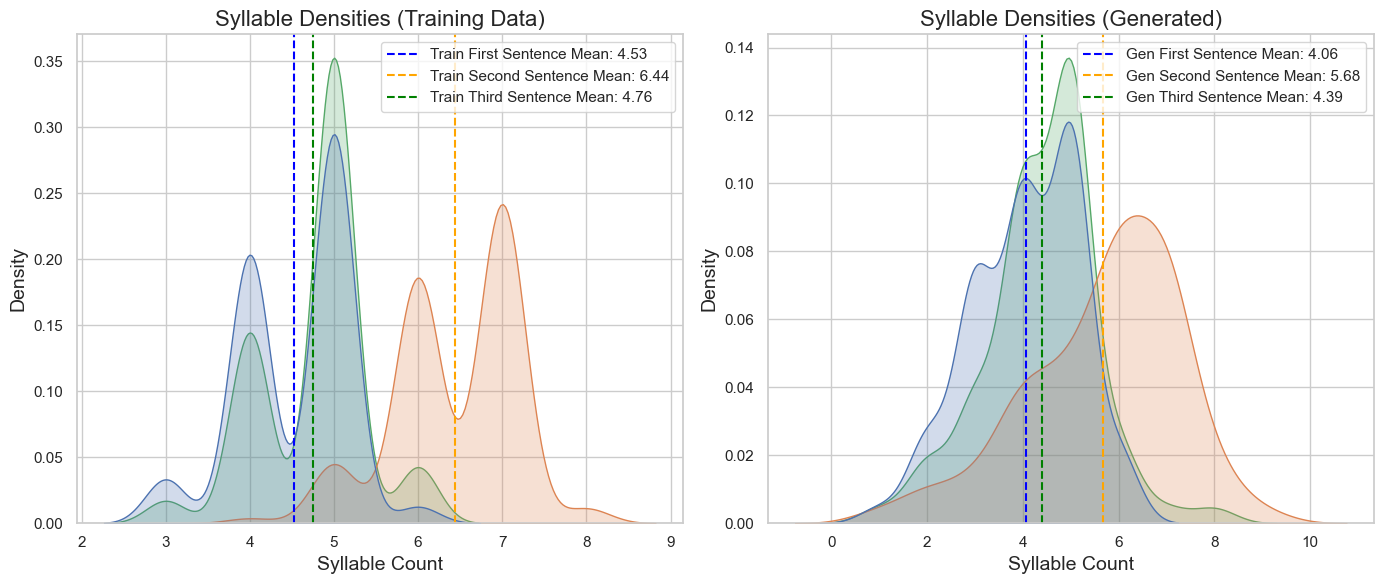

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# Create a DataFrame to hold all the syllable data
dataGenerated = pd.DataFrame({
    'Syllables': first_syllables + second_syllables + third_syllables,
    'Sentence Position': ['First'] * len(first_syllables) + 
                         ['Second'] * len(second_syllables) + 
                         ['Third'] * len(third_syllables)
})

dataTraining = pd.DataFrame({
    'Syllables': first_syllablesTrain + second_syllablesTrain + third_syllablesTrain,
    'Sentence Position': ['First'] * len(first_syllablesTrain) + 
                         ['Second'] * len(second_syllablesTrain) + 
                         ['Third'] * len(third_syllablesTrain)
})

# Calculate means
mean_first = np.mean(first_syllables)
mean_second = np.mean(second_syllables)
mean_third = np.mean(third_syllables)

# Set the style for seaborn
sns.set(style="whitegrid")

# Calculate means
mean_firstTrain = np.mean(first_syllablesTrain)
mean_secondTrain = np.mean(second_syllablesTrain)
mean_thirdTrain = np.mean(third_syllablesTrain)


# Set up the figure and the subplots (2 plots side by side)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Set the style for seaborn
sns.set(style="whitegrid")

# First subplot (on the left)
sns.kdeplot(data=dataTraining, x='Syllables', hue='Sentence Position', fill=True, ax=axes[0])

# Add vertical lines for the means (dotted lines) in the first plot
axes[0].axvline(mean_firstTrain, color='blue', linestyle='--', label=f'Train First Sentence Mean: {mean_firstTrain:.2f}')
axes[0].axvline(mean_secondTrain, color='orange', linestyle='--', label=f'Train Second Sentence Mean: {mean_secondTrain:.2f}')
axes[0].axvline(mean_thirdTrain, color='green', linestyle='--', label=f'Train Third Sentence Mean: {mean_thirdTrain:.2f}')
axes[0].set_title('Syllable Densities (Training Data)', fontsize=16)
axes[0].set_xlabel('Syllable Count', fontsize=14)
axes[0].set_ylabel('Density', fontsize=14)
axes[0].legend()

# Second subplot (on the right, copy of the first)
sns.kdeplot(data=dataGenerated, x='Syllables', hue='Sentence Position', fill=True, ax=axes[1])

# Add vertical lines for the means (dotted lines) in the second plot
axes[1].axvline(mean_first, color='blue', linestyle='--', label=f'Gen First Sentence Mean: {mean_first:.2f}')
axes[1].axvline(mean_second, color='orange', linestyle='--', label=f'Gen Second Sentence Mean: {mean_second:.2f}')
axes[1].axvline(mean_third, color='green', linestyle='--', label=f'Gen Third Sentence Mean: {mean_third:.2f}')
axes[1].set_title('Syllable Densities (Generated)', fontsize=16)
axes[1].set_xlabel('Syllable Count', fontsize=14)
axes[1].set_ylabel('Density', fontsize=14)
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()
